In [1]:
import os 
import sys
import pickle
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

import utils
import data_prep as prep

# Load prescriber summary dataset


In [23]:
npi = prep.prepare_npi(prep.npi_url)

INFO Data set PartD_Prescriber_PUF_NPI_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_NPI_15.zip
INFO successfully downloaded and uncompressed
INFO Data cleaning completed
INFO New features are added
INFO prescriber summary dataset is prepared and
INFO saved at dataset/PartD_Prescriber_PUF_NPI_15_clean.csv


In [24]:
npi.head()

,gender,zipcode,state,specialty,medicare_status,total_day_supply,bene_count,bene_avg_risk,antipsych_claims,hrm_claims,antibiotic_claims,op_claims,op_day_supply,op_bene_count,op_rate,op_prescriber,avg_op_day_supply,op_longer
npi,,,,,,,,,,,,,,,,,,
1912175340,M,95045,CA,general_surgery,E,1094,52.0,1.2440,0.0,0.0,15.0,16.0,225.0,16.0,15.09,True,14.062500,False
1417051921,F,74015,OK,physician_assistant,E,2905,195.0,0.8248,0.0,15.0,182.0,24.0,73.0,24.0,7.27,True,3.041667,False
1801093968,F,48183,MI,emergency_medicine,E,2426,133.0,1.6859,NaN,NaN,57.0,53.0,234.0,51.0,22.65,True,4.588235,False
1588763981,M,96819,HI,urology,E,54808,246.0,1.3493,0.0,11.0,96.0,42.0,423.0,27.0,5.00,True,15.666667,False
1194753186,M,49546,MI,ophthalmology,E,14683,123.0,1.4493,0.0,0.0,NaN,12.0,32.0,11.0,2.73,True,2.909091,False


We dropped sample rows if it has any NaN values for either num_op_pts or op_day_supply. About 28% of the entire dataset had NaN values for more than one of four features. We highly suspect some of these NaN values might actually represent zero values, but had to remove them because these are directly linked to the supervised classfication labels. If you don't want to drop NaN values, you can set the dropna flag as False.  

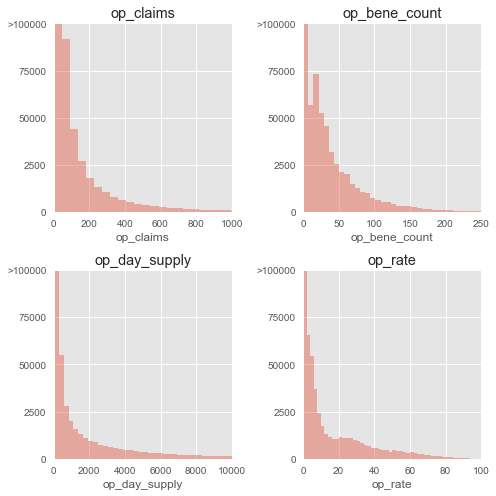

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
numerical = ['op_claims', 'op_bene_count', 'op_day_supply', 'op_rate']
xlim = [[0, 1000], [0, 250], [0, 10000], [0, 100]]
bins = [500, 500, 2000, 50]

for i, ax in enumerate(axes.flatten()):
    tmp = npi[numerical[i]].dropna()
    sns.distplot(tmp, kde=False,  ax = ax, bins=bins[i])   
    ax.set_title(numerical[i])
    ax.set_xlim(xlim[i])
    ax.set_ylim([0, 100000])
    ax.set_yticks([0, 25000, 50000, 75000, 100000])
    ax.set_yticklabels([0, 2500, 50000, 75000, ">100000"])

        
plt.tight_layout()
plt.show()

Number of opioid drugs claims, number of opioid patients, and total day's supply of opioid  basically contain the equivalent information, thus the distributions look very similar each other - peaked near zero and few outliers at exremely large values.  

Who dispensed more than 100,000 day worth of opioids??? 

In [14]:
print("{} prescribers dispensed more than 100,000 day's worth of opioids in 2015".format(len(npi[npi.op_day_supply > 100000])))
npi[npi.op_day_supply > 100000]['specialty'].value_counts()

982 prescribers dispensed more than 100,000 day's worth of opioids in 2015


Interventional Pain Management          185
Anesthesiology                          183
Physical Medicine and Rehabilitation    142
Pain Management                         135
Nurse Practitioner                       81
Physician Assistant                      68
Family Practice                          57
Internal Medicine                        51
Neurology                                31
Rheumatology                             14
Orthopedic Surgery                       10
Emergency Medicine                        7
General Practice                          6
Preventive Medicine                       2
Interventional Radiology                  2
Physical Therapist                        1
Diagnostic Radiology                      1
Psychiatry                                1
Certified Clinical Nurse Specialist       1
Sports Medicine                           1
Specialist                                1
Obstetrics/Gynecology                     1
Thoracic Surgery                

In [16]:
specialty_grouped = npi.groupby('specialty')
by_specialty = pd.DataFrame(specialty_grouped['op_day_supply'].aggregate(np.sum))
by_specialty['ratio'] = by_specialty['op_day_supply'] /  by_specialty['op_day_supply'].sum()
by_specialty = by_specialty.sort_values(by ='ratio', ascending=False)
by_specialty[:10]

,op_day_supply,ratio
specialty,,
Family Practice,487369657.0,0.283232
Internal Medicine,411261426.0,0.239002
Nurse Practitioner,157705485.0,0.091650
Physician Assistant,105087938.0,0.061071
Physical Medicine and Rehabilitation,83699095.0,0.048641
Anesthesiology,79543945.0,0.046226
Interventional Pain Management,69213486.0,0.040223
Pain Management,62309881.0,0.036211
Rheumatology,40783478.0,0.023701


About half of total opioid supply in the US are from family medicine and internal medicine, which take up 45% of the samples in out dataset. Surprisingly, non physician providers such as nurse practitioner and physician assistant contribute significant amount of opioids too, more than 15% combined. The fact that the specialty feature doesn't necessarily reflect where they actually work for might explain these high numbers.

In [17]:
by_specialty = by_specialty.sort_values(by='ratio', ascending=False)
specialty_top10 = list(by_specialty.index[:40])
npi_top10 = npi.loc[npi['specialty'].isin(specialty_top10)]
tmp = pd.crosstab(npi_top10['specialty'], npi_top10['op_prescriber'])
tmp2 = pd.crosstab(npi_top10['specialty'], npi_top10['op_prescriber'], normalize='index').iloc[:, 1]
table = pd.concat([tmp, tmp2], axis=1)
table.columns = ['Non_op_prescriber', 'op_prescriber', 'presc_ratio']
table.sort_values(by = 'presc_ratio', ascending=False)[:20]

,Non_op_prescriber,op_prescriber,presc_ratio
specialty,,,
Orthopedic Surgery,116,19156,0.993981
Interventional Pain Management,25,1567,0.984296
Pain Management,42,1769,0.976808
Plastic and Reconstructive Surgery,80,2963,0.973710
Hematology/Oncology,208,6043,0.966725
Sports Medicine,22,584,0.963696
Rheumatology,140,3595,0.962517
Medical Oncology,83,2036,0.960831
Emergency Medicine,1572,36757,0.958987


More than 99% of orthopedic surgen and hand surgen prescribed opioids in 2015. On the other hand, only about 5% of  psychiatrists prescribed opioids. We can expect that specialty feature will play an important part in the prescriber classification problem. However, this doen not necessarily mean they prescribe more opioids per patients. Let's look at the historams below. 

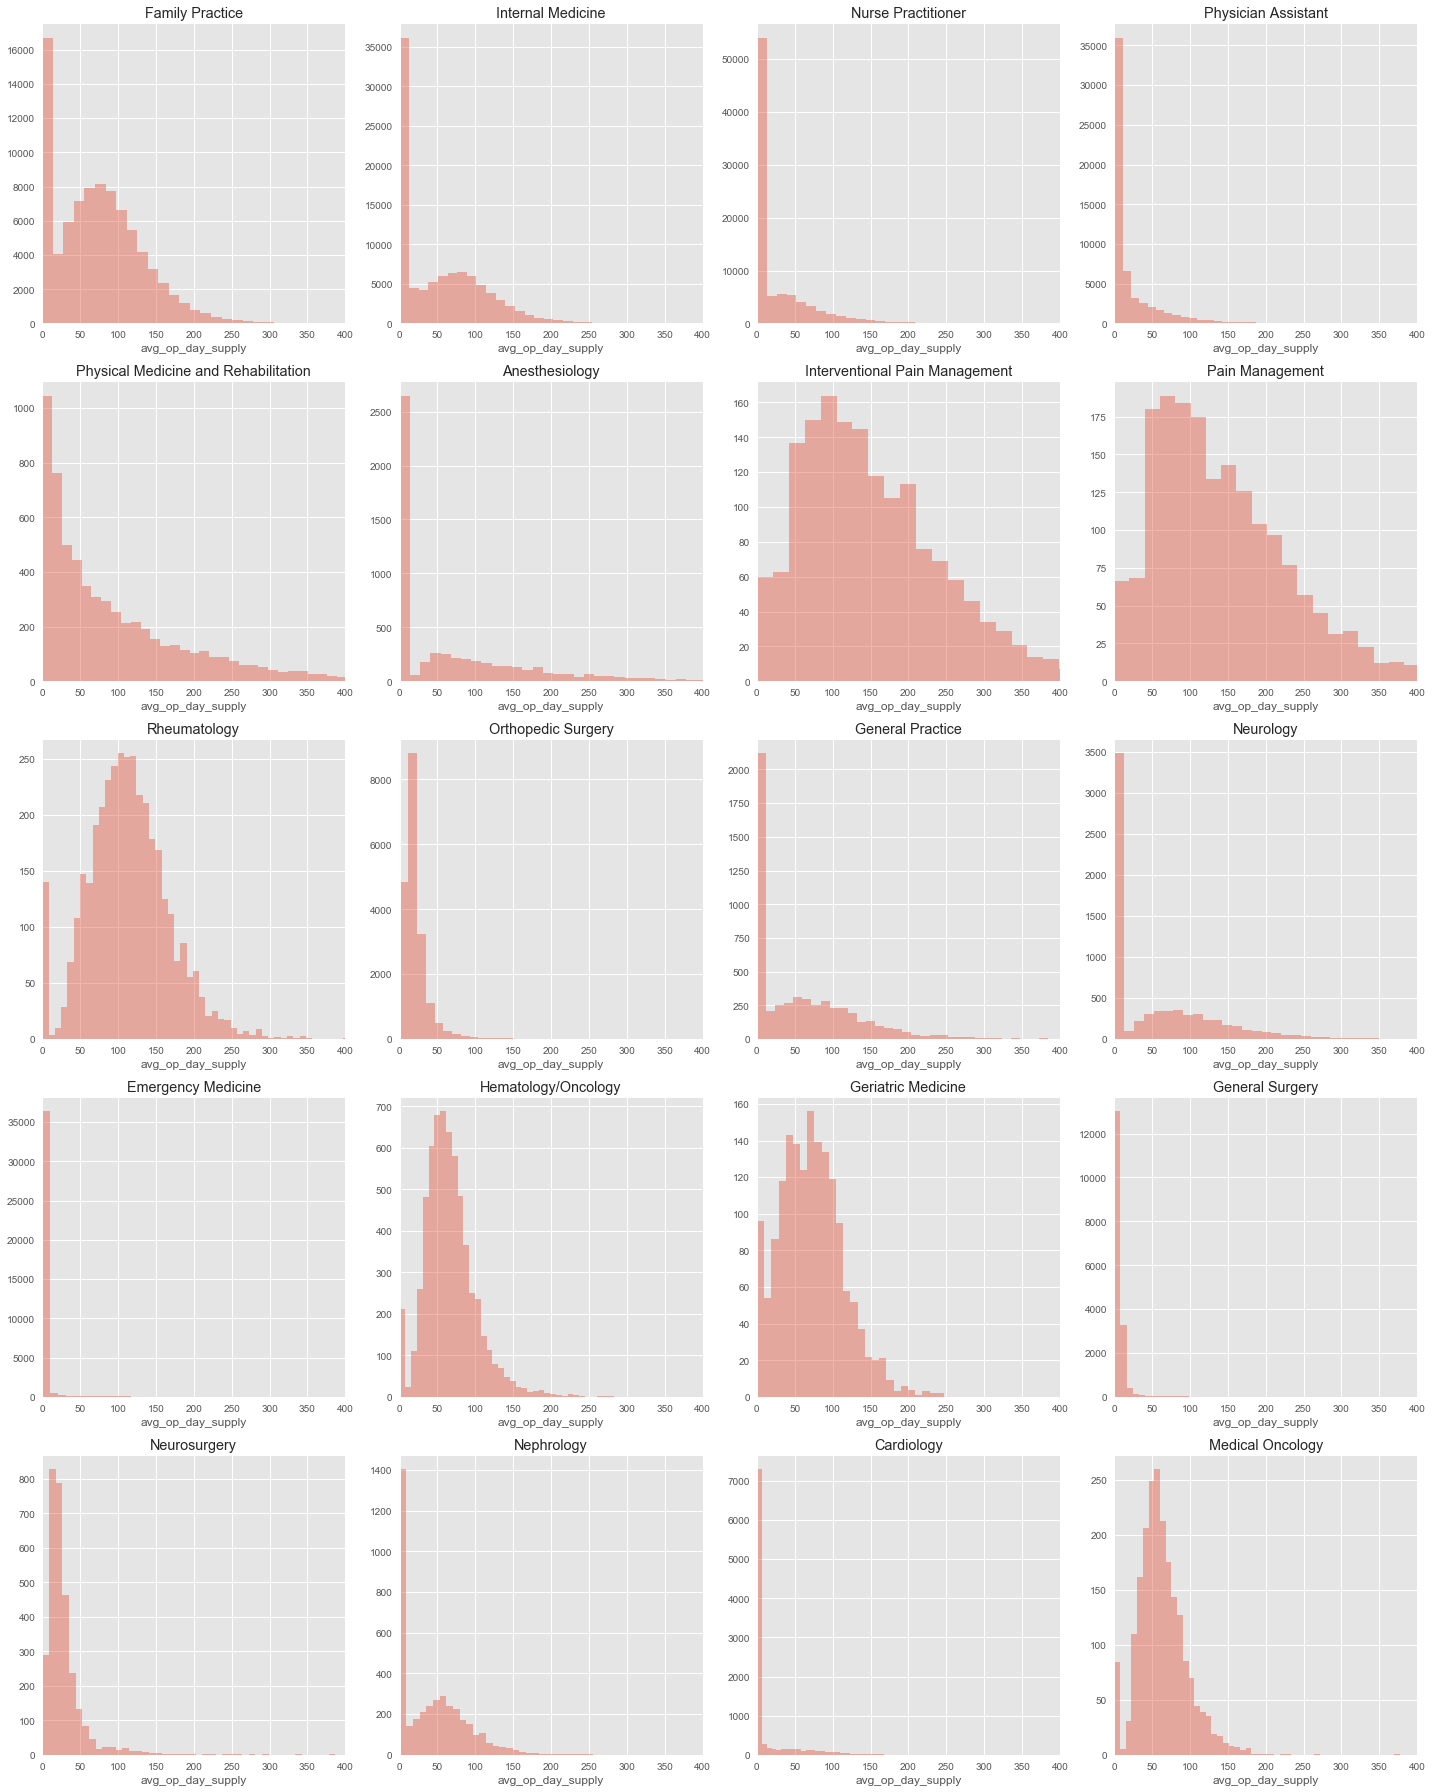

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,25))
top = list(by_specialty.index[:20])

for i, ax in enumerate(axes.flatten()):
    tmp = npi[npi['specialty'] == top[i]]['avg_op_day_supply']
    sns.distplot(tmp.dropna(), kde=False,  ax = ax)   
    ax.set_title(top[i])
    ax.set_xlim([0, 400])
    
    
plt.tight_layout()
plt.show()

The average amount of dispensed opioids drugs to each patients, given the patients got opioid prescription, varies depending on the provider's specialty. In general, specialties that involve surgery supplied less amount of opioids per patient than other non-surgery specialties. Specailties like family medicine, internal medicine, NP, PA, and cardiology seem to have mixed distribution - high peak near zero values and relatively smooth distribution at larger values.

#### Male vs Female

In [21]:
tmp = pd.concat([X, y], axis=1)
sns.countplot(x="Gender", hue="Opioid.Prescriber", data=tmp, palette=sns.husl_palette(2))
plt.show()

NameError: name 'X' is not defined

Among prefessionals with NPI, females are more likely to prescribe opioids

In [ ]:
female = tmp[tmp['Gender'] == 'F'][tmp['opioid_total'] > 0]
female_total = female['opioid_total'].sum(axis=0)
male = tmp[tmp['Gender']=='M'][tmp['opioid_total'] > 0]
male_total = male['opioid_total'].sum(axis=0)

print('The average opioid prescription of female opioid prescriber: {:.2f}'.format(female_total / female.shape[0]))
print('The average opioid prescription of male opioid prescriber: {:.2f}'.format(male_total / male.shape[0]))

pos_prescribers = tmp[tmp['Opioid.Prescriber'] == 1]
ax = sns.boxplot(x = 'Gender', y = 'opioid_total', data = pos_prescribers, palette=sns.husl_palette(2))
ax.set_yscale("log", nonposy='clip')
#ax.set_ylim(ymin=0.)
plt.show()

Among opioid prescribers, males tend to prescribe larger quantity of opiates. Note the y axis is log-scaled. The majority of prescribers prescribe mostly moderate amounts, some outliers tend to go overfew hundreds prescription during the given period. Not few male prescribers prescribed over 10,000 opioids. 

In [8]:
npi[npi.gender.isnull()]

,npi,gender,zipcode,state,specialty,medicare_status,total_day_supply,bene_count,bene_avg_risk,antipsych_claims,hrm_claims,antibiotic_claims,op_claims,op_day_supply,op_bene_count,op_rate,op_prescriber,avg_op_day_supply,op_longer
627456,1386821932,NaN,6067,CT,Nurse Practitioner,N,510,17.0,0.8060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False
662702,1629245311,NaN,85716,AZ,Nurse Practitioner,N,480,15.0,0.5855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False
662703,1073780730,NaN,32825,FL,Nurse Practitioner,N,1830,61.0,0.9631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False
662704,1306965611,NaN,30064,GA,Nurse Practitioner,N,1890,58.0,0.7212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False
662705,1356485809,NaN,60448,IL,Nurse Practitioner,N,540,16.0,1.1792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False
662706,1699748608,NaN,27519,NC,Nurse Practitioner,N,2460,78.0,0.8443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False
662707,1609076330,NaN,78749,TX,Nurse Practitioner,N,360,11.0,1.1447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False
662708,1932171634,NaN,46077,IN,Nurse Practitioner,N,330,11.0,0.6828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False
983408,1831186766,NaN,98201,WA,Optometry,N,450,15.0,0.8651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False


In [13]:
def get_dummies(npi):
    cat_to_keep = ['gender', 'state', 'specialty']
    results = {}
    for cat in cat_to_keep:
        names = npi[cat].unique()
        dummies = [cat + '_' + s for s in names]
        results[cat] = dummies
    return results['gender'] + results['state'] + results['specialty']


In [4]:
ntl, drug_name_dict = prep.get_drug_name_dict()
non_op_names, op_names = prep.get_drug_names(ntl, drug_name_dict)
drugs = prep.download_drugs()

INFO Data set PartD_Prescriber_PUF_Drug_Ntl_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_Drug_Ntl_15.zip
INFO successfully downloaded and uncompressed
INFO Data set PartD_Prescriber_PUF_NPI_DRUG_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_NPI_DRUG_15.zip
INFO successfully downloaded and uncompressed


In [34]:
def clean_drug_chunks(drugs, npi, non_op_names, op_names, scale=True, chunk_size=chunk_size):

    small = drugs.get_chunk(chunk_size)
    small = small.loc[small['bene_count'] > 0, :]
    small[ 'avg_day_supply' ] = small[ 'total_day_supply' ] / small[ 'bene_count' ]
    small[ 'generic_name' ] = utils.clean_txt(small[ 'generic_name' ])

    cols_to_keep = [ 'npi', 'generic_name', 'avg_day_supply' ]
    small = small.loc[ :, cols_to_keep ]
    small = small.set_index('npi')

    wide_table = pd.crosstab(index=small.index,
                             columns=small[ 'generic_name' ],
                             values=small[ 'avg_day_supply' ],
                             aggfunc=np.mean)

    drug_names = op_names + non_op_names
    wide_table = wide_table.loc[ :, drug_names ]
    wide_table = wide_table.fillna(0)
    wide_table.index.name = 'npi'

    # =========== feature scaling ==========
    if scale:
        wide_table = wide_table.apply(func=prep.minmax_scaler, axis=1)

    # joined by prescriber summary data
    npi_small = npi.copy()
    cols_to_keep = [ 'gender',
                     'state',
                     'specialty',
                     'medicare_status',
                     'op_prescriber',
                     'op_longer' ]
    npi_small = npi_small.loc[ :, cols_to_keep ]
    wide_table = wide_table.join(npi_small, how='inner')

    return wide_table

In [35]:
wide_table = clean_drug_chunks(drugs, npi, non_op_names, op_names, scale=True)

In [39]:
wide_table.shape

(17, 509)

In [51]:
def split_label(wide_table, npi, non_op_names, op_names, label='op_longer'):
    """
    separate labels from features 
    """

    wide_table[label] = wide_table[label].map({False: 0, True: 1})
    labels = wide_table[label]

    op_features = wide_table.loc[ :, op_names ]
    
    op_labels = [ 'op_longer', 'op_prescriber' ]
    cols_to_drop = op_names + op_labels
    
    features = wide_table.drop(cols_to_drop, axis=1)
    features = pd.get_dummies(features)
    
    cols_to_keep = prep.get_dummies(npi) + non_op_names
    features = features.loc[:, cols_to_keep].fillna(0)

    return features, op_features, labels


In [46]:
def get_minibatch(drugs, npi, non_op_names, op_names, pred_longer=True, chunk_size=200000):

    batches = {
        'features': [],
        'labels': [],
        'n_features': []
    }

    try:
        for i in range(5):
            X, y = prep.clean_drug_chunks(drugs, npi, non_op_names, op_names, pred_longer=True, chunk_size=chunk_size)
            batches['features'].append(X)
            batches['labels'].append(y)
            batches['n_features'].append(X.shape[1])
            #save_objects(X, y, i)
            print(i)
            print(X.shape)

    except StopIteration:
        return None, None

    return batches

In [36]:
def fix_columns(batches):
    

0
(5127, 390)
1
(4737, 388)
2
(4919, 391)
3
(5003, 388)
4
(5071, 386)


In [44]:
len(op_names + non_op_names)

253

In [41]:
tmp = batches['features'][2].columns
tmp1 = batches['features'][4].columns
np.setdiff1d(tmp, tmp1)

array(['specialty_Clinic/Center', 'specialty_Clinical Psychologist',
       'specialty_Geriatric Psychiatry',
       'specialty_Interventional Radiology',
       'specialty_Osteopathic Manipulative Medicine',
       'specialty_Sleep Medicine',
       'specialty_Thoracic Surgery (Cardiothoracic Vascular Surgery)'], dtype=object)

In [283]:
wide_table_sc = wide_table.apply(func=minmaxscaler, axis=1)

    # joined by prescriber summary data
npi_small = npi.copy()
cols_to_keep = [ 'npi', 'gender', 'state', 'specialty',
                     'medicare_status', 'op_prescriber', 'op_longer' ]
npi_small = npi_small.loc[ :, cols_to_keep ]
npi_small = npi_small.set_index('npi')

wide_table = wide_table_sc.join(npi_small, how='inner')

In [286]:
labels = wide_table[ 'op_longer' ]
features = wide_table.drop([ 'op_longer', 'op_prescriber' ], axis=1)
features = pd.get_dummies(features)

In [290]:
features.columns

Index(['acetaminophen_with_codeine', 'codeine_butalbital_asa_caffein',
       'morphine_sulfate', 'buprenorphine_hcl',
       'butalbit_acetamin_caff_codeine', 'butorphanol_tartrate',
       'buprenorphine', 'codeine_sulfate', 'hydromorphone_hcl', 'fentanyl',
       ...
       'specialty_Specialist', 'specialty_Sports Medicine',
       'specialty_Student in an Organized Health Care Education/Training Program',
       'specialty_Surgical Oncology', 'specialty_Thoracic Surgery',
       'specialty_Urology', 'specialty_Vascular Surgery', 'medicare_status_E',
       'medicare_status_N', 'medicare_status_O'],
      dtype='object', length=460)

In [239]:
import time

def clean_drug_chunks(drugs, npi, non_op_names, op_names, pred_longer=True, chunk_size=100000):
    
    small = drugs.get_chunk(chunk_size)
    small[ 'avg_day_supply' ] = small[ 'total_day_supply' ] / small[ 'bene_count' ]
    small[ 'generic_name' ] = utils.clean_txt(small[ 'generic_name' ])
    cols_to_keep = [ 'npi', 'generic_name', 'avg_day_supply' ]
    small = small.loc[ :, cols_to_keep ]
    small = small.set_index('npi')
    #small = small.dropna()
    wide_table = pd.crosstab(index=small.index,
                             columns=small[ 'generic_name' ],
                             values=small[ 'avg_day_supply' ],
                             aggfunc=np.mean)
    drug_names = op_names + non_op_names
    wide_table = wide_table.loc[ :, drug_names ]
    wide_table = wide_table.fillna(0)
    wide_table.index.name = 'npi'
    
    #=========== feature scaling ==========
    wide_table_sc = wide_table.apply(func=minmaxscaler, axis=1)
    
    
    # joined by prescriber summary data
    npi_small = npi.copy()
    cols_to_keep = ['npi', 'gender', 'state', 'specialty', 
                    'medicare_status', 'op_prescriber', 'op_longer']
    npi_small = npi_small.loc[:, cols_to_keep]
    npi_small = npi_small.set_index('npi')

    wide_table = wide_table_sc.join(npi_small, how='inner')
    
    # =========== one hot encoding ==========
    wide_table = pd.get_dummies(wide_table)
    wide_table = wide_table.dropna()
    
    # ========== separate labels from features ==========
    if pred_longer:
        labels = wide_table['op_longer']
        features = wide_table.drop(['op_longer', 'op_prescriber'], axis=1)
        return features, labels
    
    else:
        labels = wide_table['op_prescriber']
        cols_to_drop = op_names + ['op_longer', 'op_prescriber']
        op_features = wide_table.loc[:, op_names]
        features = wide_table.drop(cols_to_drop, axis=1)
        return features, op_features, labels

In [240]:
features, op_features, labels = clean_drug_chunks(drugs, npi, non_op_names, op_names, pred_longer=False, chunk_size=200000)

In [241]:
features.head(20)

,potassium_chloride,nitroglycerin,spironolactone,methylprednisolone,ezetimibe_simvastatin,insulin_detemir,etodolac,"pen_needle,_diabetic",cyclosporine,valsartan,metoprolol_succinate,amlodipine_besylate,fluocinolone_acetonide,verapamil_hcl,insulin_lispro,fluoxetine_hcl,duloxetine_hcl,levothyroxine_sodium,budesonide_formoterol_fumarate,dutasteride,clopidogrel_bisulfate,brimonidine_tartrate,levothyroxine_sodium,ciclopirox,paroxetine_hcl,baclofen,omeprazole,donepezil_hcl,azithromycin,prednisolone,atorvastatin_calcium,carbamazepine,fluticasone_propionate,oseltamivir_phosphate,dorzolamide_hcl_timolol_maleat,meclizine_hcl,prednisone,albuterol_sulfate,naproxen,carvedilol,pilocarpine_hcl,famotidine,midodrine_hcl,oxybutynin_chloride,fenofibrate,mupirocin,brinzolamide,testosterone_cypionate,ciprofloxacin_hcl,warfarin_sodium,isosorbide_dinitrate,collagenase_clostridium_hist.,"syringe_w_ndl,_disp.,_insulin",lactulose,sertraline_hcl,insulin_detemir,omega_3_acid_ethyl_esters,clonidine_hcl,prochlorperazine_maleate,roflumilast,calcipotriene,fenofibrate_nanocrystallized,alogliptin_benz_pioglitazone,trazodone_hcl,clonidine,imatinib_mesylate,carbamazepine,polyethylene_glycol_3350,pravastatin_sodium,risedronate_sodium,diclofenac_sodium,"syring_w_ndl,disp,insul,0.3_ml",lactulose,bumetanide,tamsulosin_hcl,albuterol_sulfate,emtricitabine_tenofovir,liraglutide,furosemide,levocetirizine_dihydrochloride,verapamil_hcl,phenazopyridine_hcl,erythromycin_base_ethanol,lisinopril_hydrochlorothiazide,lidocaine_prilocaine,lithium_carbonate,nitroglycerin,fluocinolone_shower_cap,alprazolam,exenatide_microspheres,levetiracetam,atenolol,ranitidine_hcl,valacyclovir_hcl,allopurinol,diltiazem_hcl,nystatin_triamcin,gemfibrozil,diazepam,meloxicam,ondansetron_hcl,metoprolol_tartrate,desonide,propranolol_hcl,albiglutide,ipratropium_albuterol_sulfate,carbamazepine,insulin_aspart,metronidazole,terazosin_hcl,pitavastatin_calcium,nystatin,bupropion_hcl,ketoconazole,azilsartan_medoxomil,fluocinonide,memantine_hcl,chlorhexidine_gluconate,ibuprofen,enalapril_maleate,metoprolol_succinate,ropinirole_hcl,betamethasone_dipropionate,ondansetron,lamotrigine,lamotrigine,nortriptyline_hcl,brimonidine_tartrate,"insulin_glargine,hum.rec.anlog",gabapentin,itraconazole,testosterone,terbutaline_sulfate,celecoxib,diltiazem_hcl,donepezil_hcl,"syr_w_ndl,ins_0.3_ml_half_mark",losartan_potassium,lovastatin,umeclidinium_bromide,pantoprazole_sodium,glipizide,ramipril,sumatriptan,methotrexate_sodium,beclomethasone_dipropionate,fluticasone_propionate,bupropion_hcl,estradiol,valsartan,...,fluphenazine_decanoate,fluphenazine_hcl,ziprasidone_hcl,ziprasidone_mesylate,haloperidol,haloperidol_lactate,haloperidol_decanoate,paliperidone,paliperidone_palmitate,lurasidone_hcl,loxapine_succinate,olanzapine,olanzapine_fluoxetine_hcl,pimozide,perphenazine,perphenazine_amitriptyline_hcl,quetiapine_fumarate,brexpiprazole,risperidone,risperidone_microspheres,asenapine_maleate,thioridazine_hcl,thiothixene,trifluoperazine_hcl,gender_F,gender_M,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,specialty_Addiction Medicine,specialty_Allergy/Immunology,specialty_Anesthesiology,specialty_Cardiac Electrophysiology,specialty_Cardiac Surgery,specialty_Cardiology,specialty_Certified Clinical Nurse Specialist,specialty_Certified Nurse Midwife,specialty_Clinical Psychologist,specialty_Colorectal Surgery (formerly proctology),specialty_Critical Care (Intensivists),specialty_Dentist,specialty_Dermatology,specialty_Diagnostic Radiology,specialty_Emergency Medicine,specialty_Endocrinology,specialty_Family Practice,specialty_Gastroe

In [243]:
labels.value_counts()

True     3447
False     885
Name: op_prescriber, dtype: int64

In [ ]:
size = 1000

features, labels = [], []
try:
    for _ in range(size):
        X, y =  clean_drug_chunks(drugs, npi, non_op_names, op_names, pred_longer=True, chunk_size=100000)
        features.append(X)
        labels.appned(y)
except StopIteration:
    return None, None



In [249]:
def get_minibatch(drugs, npi, non_op_names, op_names, pred_longer=True, chunk_size=100000):
    
    features, labels = [], []
    try:
        for i in range(5):
            X, y =  clean_drug_chunks(drugs, npi, non_op_names, op_names, pred_longer=True, chunk_size=100000)
            features.append(X)
            labels.append(y)
            print(i)
    except StopIteration:
        return None, None
    
    return features, labels


In [250]:
features, labels = get_minibatch(drugs, npi, non_op_names, op_names, pred_longer=True, chunk_size=100000)

0
1
2
3
4


In [254]:
labels[0].value_counts()

False    2063
True       53
Name: op_longer, dtype: int64

In [57]:
def split_test(batch_dir="dataset/batches", test_ratio=0.15):
    filepath_list = glob.glob(os.path.join(batch_dir, "*.pickle"))
    n_batches = len(filepath_list)
    n_test = int(test_ratio * n_batches)
    np.random.RandomState(random_state)
    test_batch_names = np.random.choice(filepath_list, n_test, replace=False)
    
    new_test_batch_names = [ (b, os.path.join('dataset/batches/test_batches', b.split("/")[ -1 ])) \
                             for b in test_batch_names ]
    for names in new_test_batch_names:
        os.rename(names[ 0 ], names[ 1 ])

    train_batch_names = np.setdiff1d(filepath_list, test_batch_names)
    new_train_batch_names = [ (b, os.path.join('dataset/batches/train_batches', b.split("/")[ -1 ])) \
                              for b in train_batch_names ]
    for names in new_train_batch_names:
        os.rename(names[ 0 ], names[ 1 ])

    logging.info("Number of test batches: {}".format(len(new_test_batch_names)))
    logging.info("Number of train batches: {}".format(len(new_train_batch_names)))

    return test_batch_names, train_batch_names

In [61]:
import glob
import logging
random_state=42
split_test()

ValueError: a must be non-empty

In [27]:
with open('models/best.pickle', 'rb') as f:
    best_ = pickle.load(f)

In [28]:
best_.coef_

array([[ -1.12678528e-02,  -7.11345834e-01,  -5.76969662e-01,
          2.65183432e-01,  -2.66510027e-01,   9.80343373e-02,
         -1.65280576e+00,  -3.41515890e-01,   3.17569511e-01,
          9.55855031e-01,   9.98364453e-01,   5.61716824e-01,
         -2.06112022e-01,  -2.13279255e+00,   9.18002790e-01,
          1.12514841e-01,  -1.21815193e+00,   2.97529263e-01,
          1.44104836e-01,   1.16903491e-01,   1.41835342e-01,
          8.08506009e-01,  -1.75510217e+00,   6.18372141e-01,
          1.28909828e+00,   1.16912323e+00,  -3.33311532e-01,
          6.00019861e-02,  -3.37210781e+00,   8.94702420e-01,
          1.50263775e-01,  -4.95564749e-01,  -2.36902333e+00,
          4.84118485e-01,   7.65492804e-01,  -7.64131594e-01,
         -5.75003010e-01,  -8.45464149e-01,   6.73209423e-01,
          1.20996409e-01,  -8.83506311e-02,  -4.29854840e-01,
          5.07640882e-01,   1.12850268e+00,  -1.52752835e+00,
          1.06395928e+00,   7.89940206e-01,   2.68309622e-01,
        